# Nonlinear SVM Classification

## About Dataset

`make_moons` toy dataset for binary classification

## Import Libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier

## Import Dataset

In [2]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

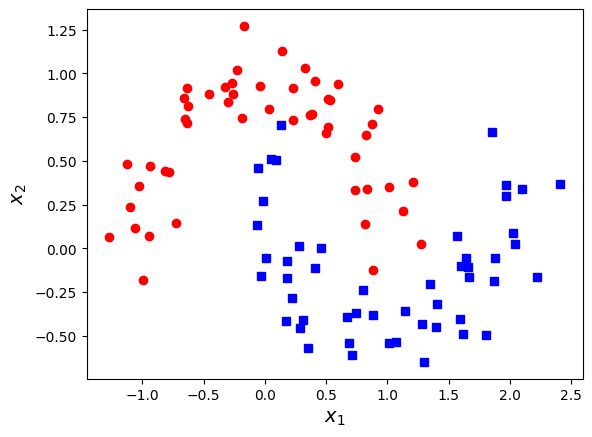

In [3]:
# Plot make_moons dataset
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14)

plot_dataset(X, y)
plt.show()

## Create Pipeline

In [4]:
# Pipeline will contain PolynomialFeatures, StandardScaler and LinearSVC
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

# Fit data
polynomial_svm_clf.fit(X, y)

C:\Users\ttomk\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

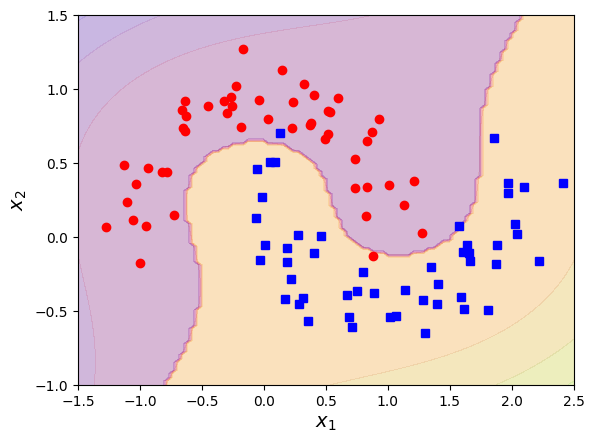

In [5]:
# Compute predictions and plot data with Linear SVM classifier using polynomial features
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.plasma, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y)
plt.show()

## Kernel Trick

In [6]:
# Create pipeline using StandardScaler and SVC with 3rd degree polynomial kernel and hyperparameter coef0 = 1
poly_kernel_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [7]:
# Create pipeline using StandardScaler and SVC with 10th degree polynomial kernel and hyperparameter coef0 = 100
poly100_kernel_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
])
poly100_kernel_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

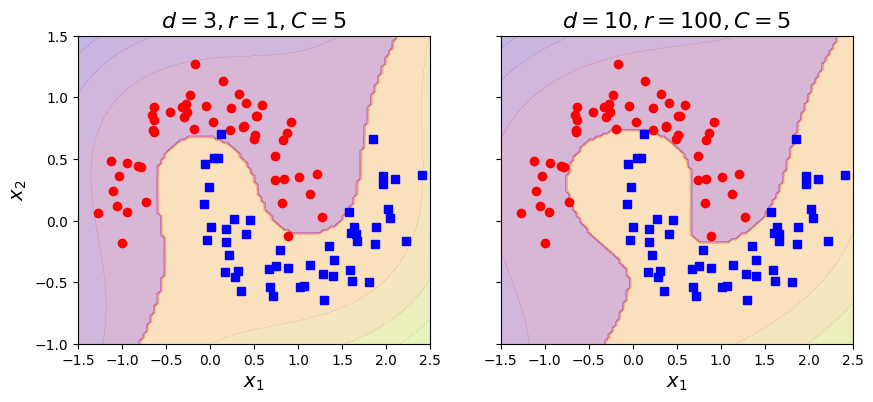

In [8]:
# Plot SVM classifiers with a polynomial kernel
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_dataset(X, y)
plot_predictions(poly_kernel_clf, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=16)

plt.sca(axes[1])
plot_dataset(X, y)
plot_predictions(poly100_kernel_clf, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=16)
plt.ylabel("")
plt.show()

## Gaussian RBF Kernel

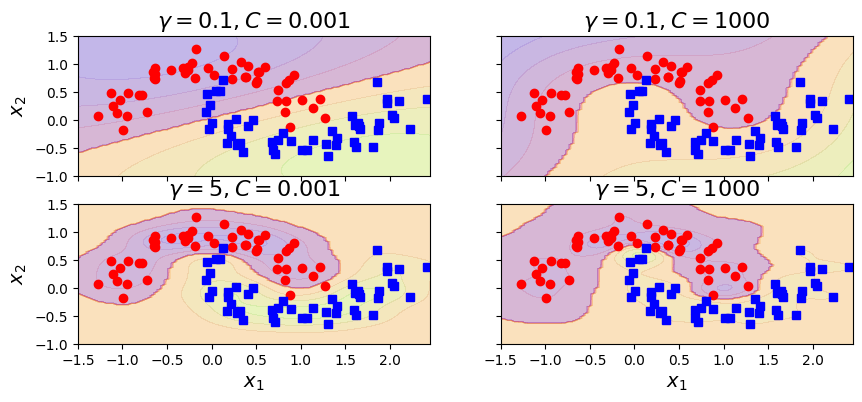

In [9]:
# Similar to polynomial features method Gaussian RBF kernel can be used
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
    ])
    rbf_kernel_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_clf)
    
# Plot SVM classifiers
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 4), sharex=True, sharey=True)
for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y)
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")
        
plt.show()        

The models are trained with different values of hyperparameters $\gamma$ and C. Increasing $\gamma$ the bell shaped curve becomes narrower (plots on the left) and as a result instances have smaller range of influence and the decision boundary is more irregular. $\gamma$ is like a regularization hyperparameter similar to C hyperparameter.

## Decision Tree Classifier

In [23]:
# Train Decision Tree without regularization
X, y = make_moons(n_samples=100, noise=0.15, random_state=53)
tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf1.fit(X, y)

DecisionTreeClassifier(random_state=42)

In [24]:
# Train Decision Tree with regularization using min_samples_leaf
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
tree_clf2.fit(X, y)

DecisionTreeClassifier(min_samples_leaf=4, random_state=42)

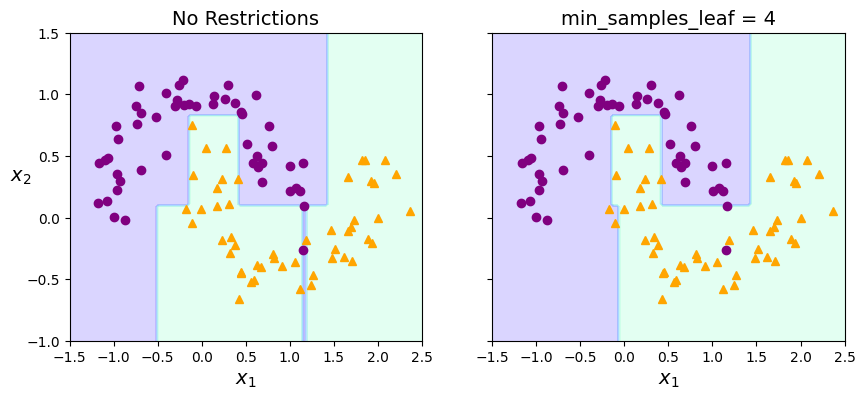

In [25]:
# Plot decision trees with and without restriction
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.4, 0, 3], legend=False, plot_train=True):
    X1s = np.linspace(-1.5, 2.5, 100)
    X2s = np.linspace(-1, 1.5, 100)
    X1, X2 = np.meshgrid(X1s, X2s)
    X_new = np.c_[X1.ravel(), X2.ravel()]
    y_pred = clf.predict(X_new).reshape(X1.shape)
    custom_cmap = ListedColormap(["#8576FF", "#7BC9FF", "#A3FFD6"])
    plt.contourf(X1, X2, y_pred, alpha=0.3, cmap=custom_cmap)
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
    if plot_train:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "o",color="purple", label="Iris Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "^", color="orange", label="Iris Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "ys", label="Iris Virginica")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X, y)
plt.title("No Restrictions", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X, y)
plt.title("min_samples_leaf = {}".format(tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")
plt.show()

The model on the left is overfitting and the model on the right will probably generalize better.